In [2]:
import os
import time
import gc
import warnings
warnings.filterwarnings("ignore")
# data manipulation

import numpy as np
import pandas as pd
# plot
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
# model
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import gc, sys 
gc.enable()

In [3]:
train = pd.read_pickle('train_feature.pkl')

In [4]:
train.columns.unique()

Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
       'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc', 'totalDistance', 'teamSize_x', 'teamSize_y',
       'killsRatio', 'headshotRate', 'itemsRatio', 'skillfull',
       'healsPerWalkDistance', 'teamwork', 'killsPertotalDistance'],
      dtype='object')

In [ ]:
train.drop(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
            'killPoints', 'kills', 'killStreaks', 'longestKill',
            'matchDuration', 'matchType', 'maxPlace', 'numGroups', 'rankPoints',
            'revives', 'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
            'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
            'teamSize_x', 'teamSize_y'])


In [4]:
x = train.drop('winPlacePerc', axis=1)
y = train['winPlacePerc']

In [5]:
%%time
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42)


CPU times: total: 4.44 s
Wall time: 4.91 s


In [18]:
%%time
train_index = round(int(x_train.shape[0]*0.8))
dev_X = x_train[:train_index]
val_X = x_train[train_index:]
dev_y = y_train[:train_index]
val_y = y_train[train_index:]
gc.collect()


def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective": "regression", "metric": "mae", 'n_estimators': 5000, 'early_stopping_rounds': 200,
              "num_leaves": 31, "learning_rate": 0.03, "bagging_fraction": 0.9,
              "bagging_seed": 0, "num_threads": 4, "colsample_bytree": 0.7
              }

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, valid_sets=[
                      lgtrain, lgval], early_stopping_rounds=200, verbose_eval=100)

    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model


# Training the model #
pred_test, model = run_lgb(dev_X, dev_y, val_X, val_y, x_test)


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.513358 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4633
[LightGBM] [Info] Number of data points in the train set: 2048712, number of used features: 35
[LightGBM] [Info] Start training from score 0.526415
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0708457	valid_1's l1: 0.0708337
[200]	training's l1: 0.0622623	valid_1's l1: 0.0623495
[300]	training's l1: 0.0599764	valid_1's l1: 0.0601138
[400]	training's l1: 0.0589198	valid_1's l1: 0.0590971
[500]	training's l1: 0.0583427	valid_1's l1: 0.0585531
[600]	training's l1: 0.057979	valid_1's l1: 0.0582145
[700]	training's l1: 0.0577211	valid_1's l1: 0.0579794
[800]	training's l1: 0.0575272	valid_1's l1: 0.057808
[900]	training's l1: 0.0573768	valid_1's l1: 0.0576813
[1000]	training's l1: 0.0572485	va

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

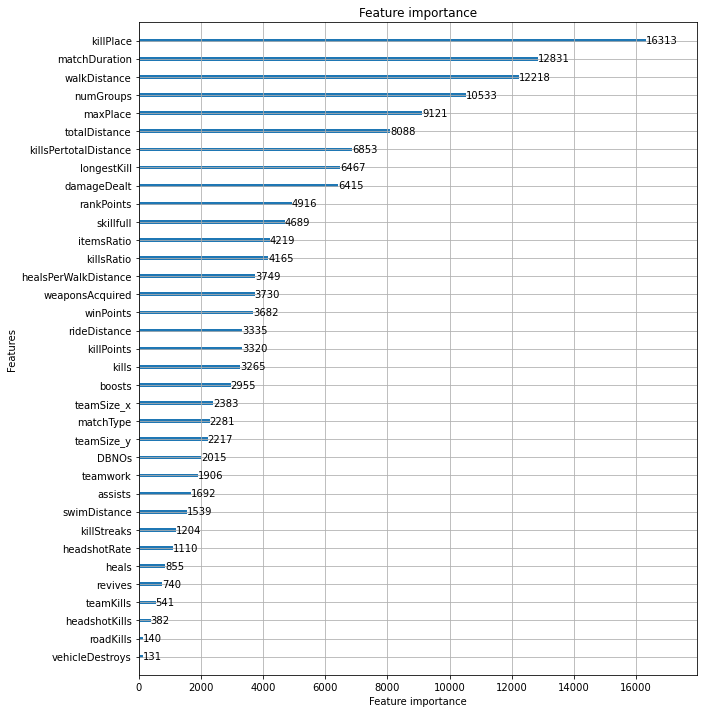

In [21]:
from lightgbm import plot_importance
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [ ]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [
        3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           return_train_score=True)

grid_search.fit(x_train, y_train )


In [36]:
rf.fit(x_train, y_train)